In [1]:
%%capture
pip install -q --upgrade "scikit-learn==1.3.2" "imbalanced-learn==0.11.0"


# Pima Indians Diabetes Prediction
# Executive Summary
Imagine if you could predict diabetes early—before symptoms appear—using just routine checkup data.
In this project, we dive into the Pima Indians Diabetes Dataset to build a robust ML model for diabetes prediction.
We walk through the full data science process: cleaning, EDA, feature engineering, modeling, interpretation, and actionable insights.


## Background

Diabetes is a global health crisis. Early diagnosis is critical to prevent serious complications.
This dataset from the National Institute of Diabetes contains medical details for 768 adult females of Pima Indian heritage (aged 21+). Our aim: build a predictive tool to assist early clinical decisions.


## Data Dictionary

| Feature         | Description                                            |
|-----------------|-------------------------------------------------------|
| Pregnancies     | Number of times pregnant                              |
| Glucose         | Plasma glucose concentration (mg/dL)                  |
| BloodPressure   | Diastolic blood pressure (mm Hg)                      |
| SkinThickness   | Triceps skinfold thickness (mm)                       |
| Insulin         | 2-Hour serum insulin (mu U/ml)                        |
| BMI             | Body mass index (weight in kg/(height in m)^2)        |
| DiabetesPedigree| Diabetes pedigree function                            |
| Age             | Age (years)                                           |
| Outcome         | 1 = diabetes, 0 = non-diabetes                       |


# Data Preparation & Preprocessing

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import os, warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_context('notebook', font_scale=1.2)
pd.set_option('display.max_columns', None)



# Data Loading 

In [3]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")


# Initial Data Exploration

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
df.shape

(768, 9)

# Data Cleaning & Preprocessing

## Check missing values & duplicates


In [8]:
# Missing values 
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
# Remove duplicates
df.duplicated().sum()

0

No explicit nulls. Zeros in some columns represent missing data

## Replace Impossible Zeros with NaN

In [10]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.NaN)
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


##  Impute Missing Values (Median)

In [11]:
for col in cols_with_zero:
    df[col].fillna(df[col].median(), inplace=True)
print("Nulls after imputation:")
print(df.isnull().sum())   

Nulls after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Using median is robust to outliers—especially for medical data.



## Outlier detection (using IQR)


In [12]:
for col in cols_with_zero:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    print(f"Outliers in {col}: {outliers.shape[0]}")


Outliers in Glucose: 0
Outliers in BloodPressure: 14
Outliers in SkinThickness: 87
Outliers in Insulin: 346
Outliers in BMI: 8


Most features are now reasonably distributed after cleaning and imputation.

# Feature Engineering

## Age Groups

In [13]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[20,30,40,50,60,100], labels=['20s','30s','40s','50s','60s+'])

## BMI Categories

In [14]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100], labels=['Underweight','Normal','Overweight','Obese'])

## New features

In [15]:
df['Age_BMI'] = df['Age'] * df['BMI']
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Preg_Age_Ratio'] = df['Pregnancies'] / (df['Age']+1)

Creating compound features to capture complex risk interactions.



# Exploratory Data Analysis (EDA) & Visualization

## Class Imbalance Visualization

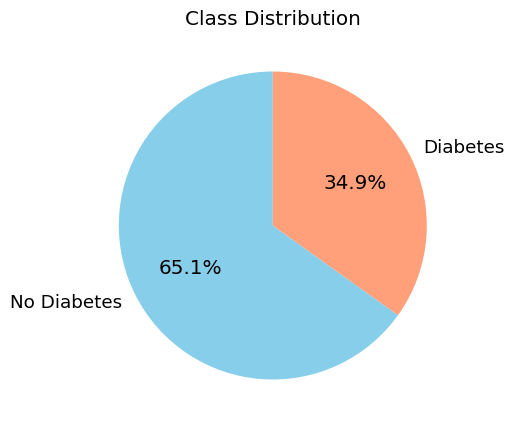

In [16]:
plt.figure(figsize=(5,5))
df['Outcome'].value_counts().plot.pie(
    labels=['No Diabetes','Diabetes'],
    autopct='%1.1f%%',
    colors=['#87CEEB','#FFA07A'],
    startangle=90
)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

About 65% of cases are non-diabetic and 35% diabetic. Class imbalance may bias models toward majority class.


## Pairplot

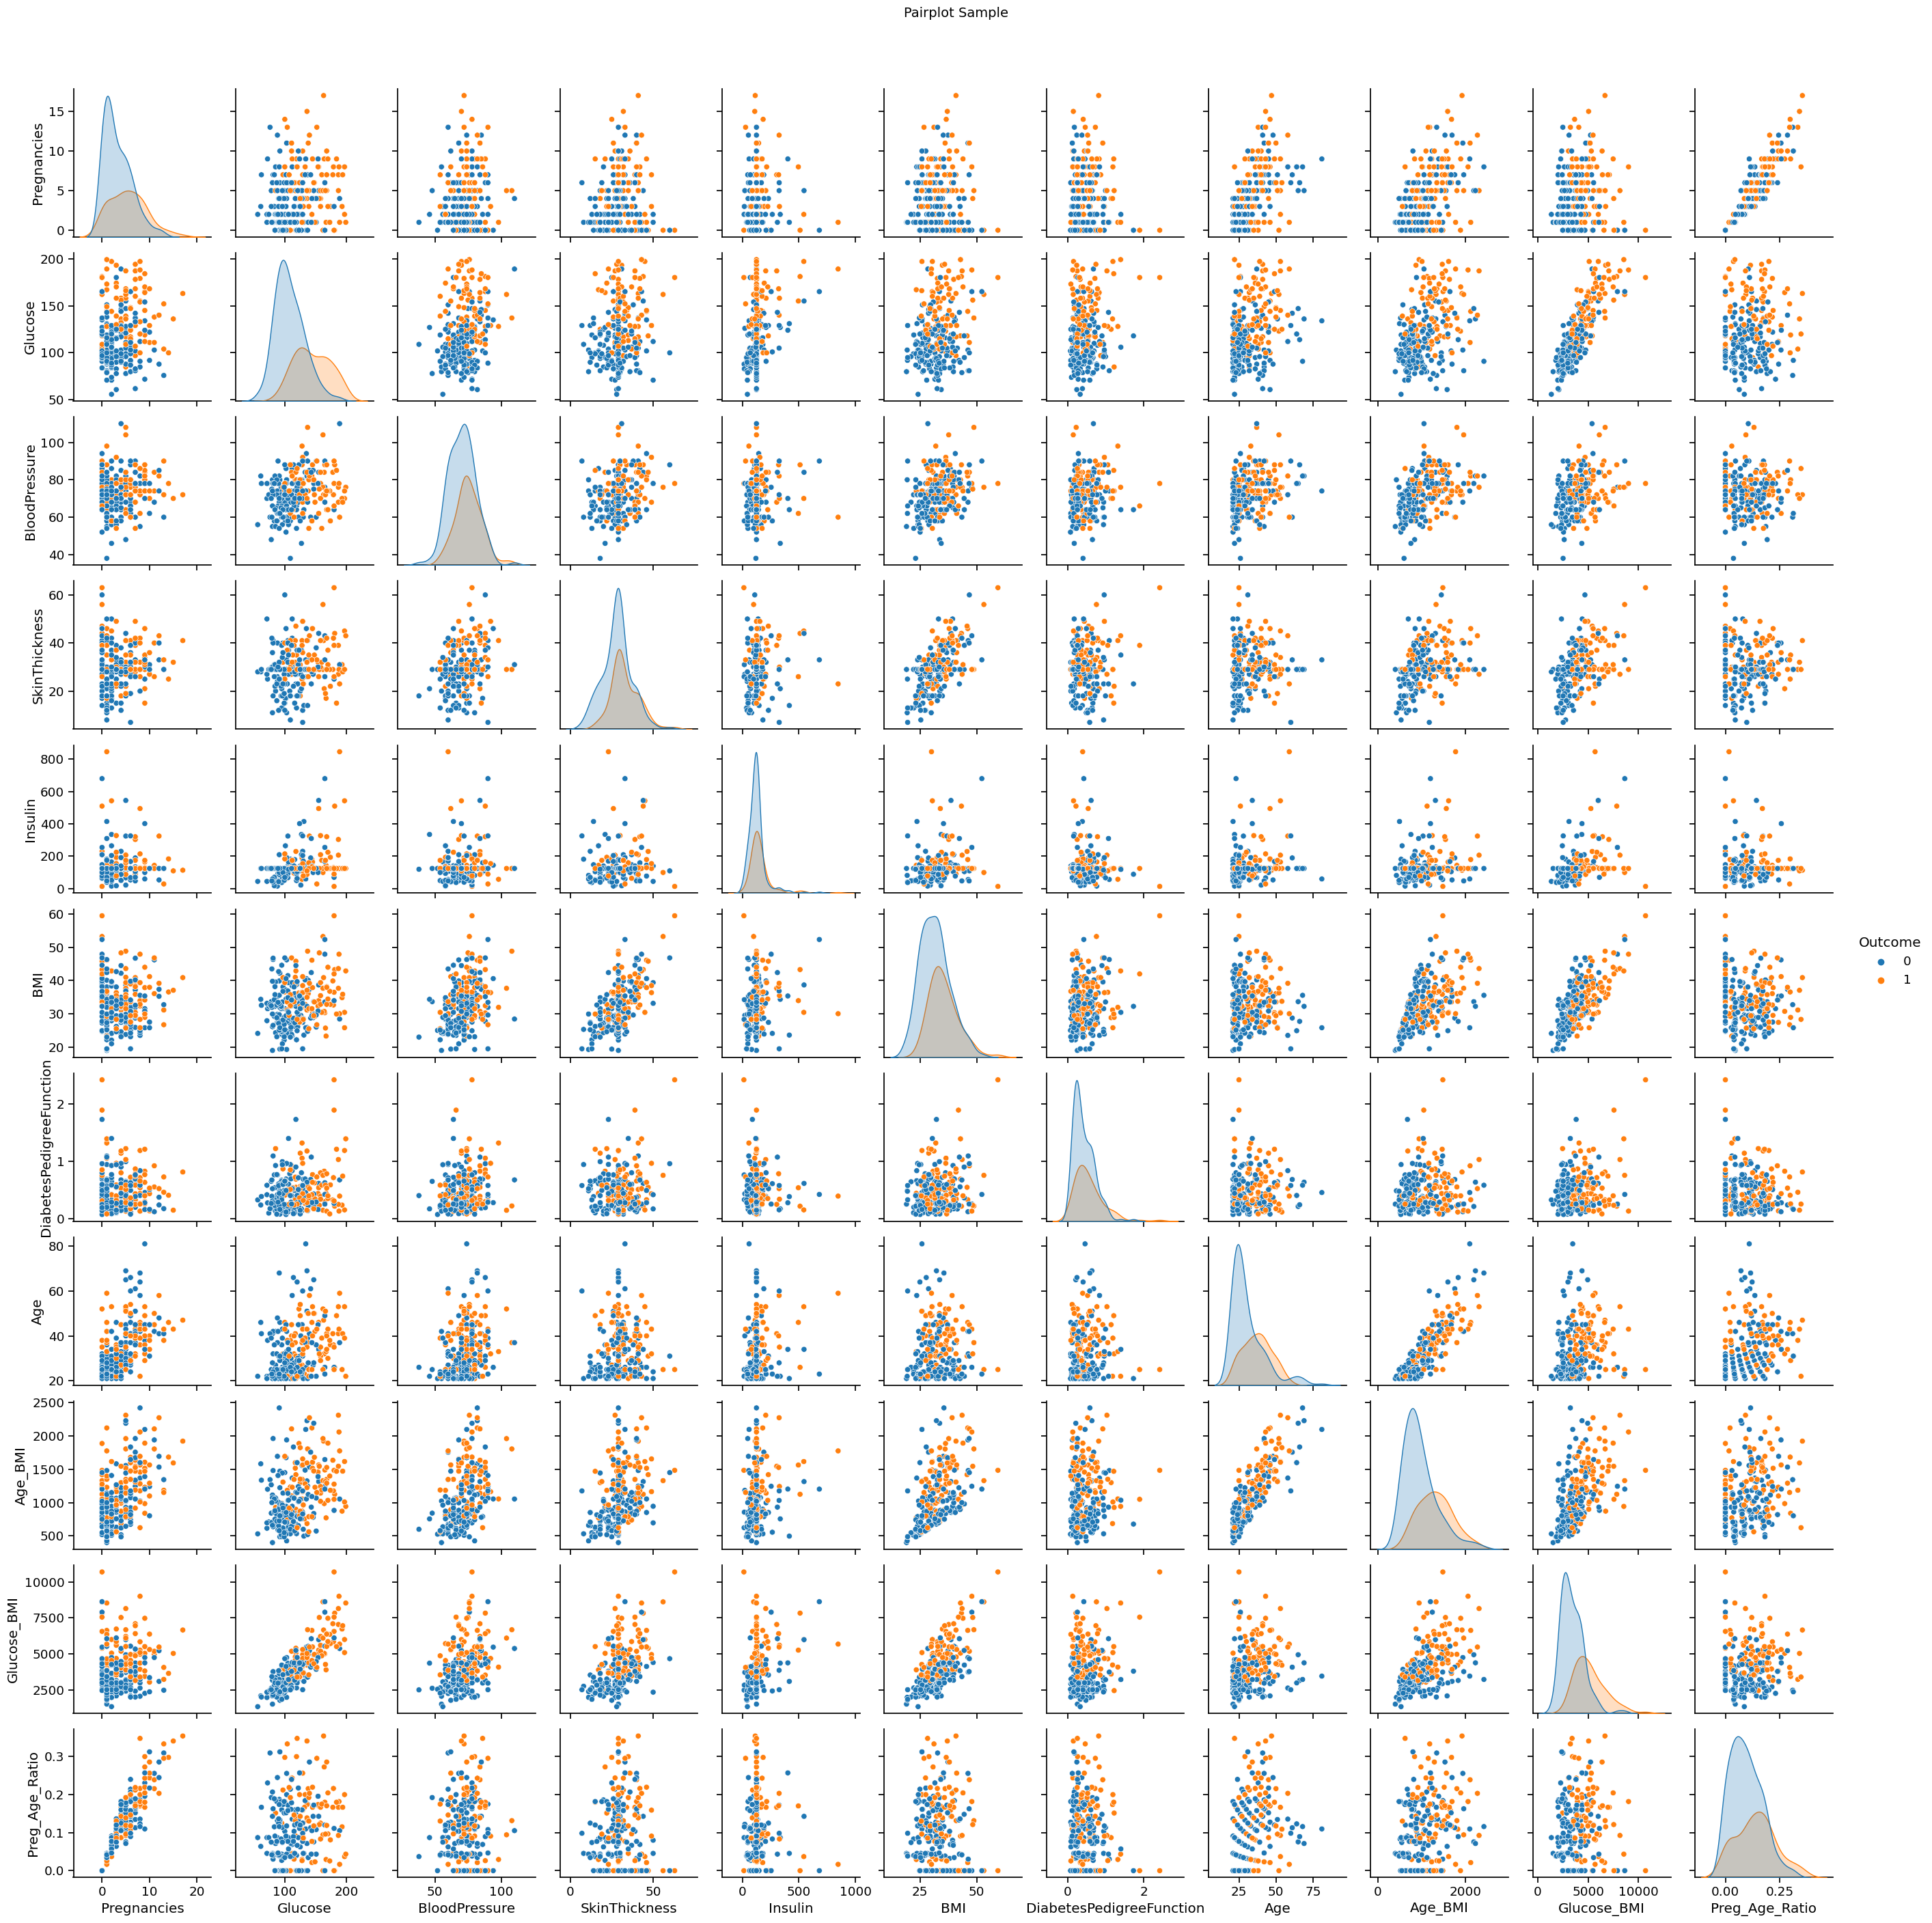

In [17]:
sns.pairplot(df.sample(250, random_state=1), hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot Sample", fontsize=14, y= 1.03)
plt.show()

Pairplot shows that most diabetic cases cluster at high Glucose and BMI values.


## Jointplot

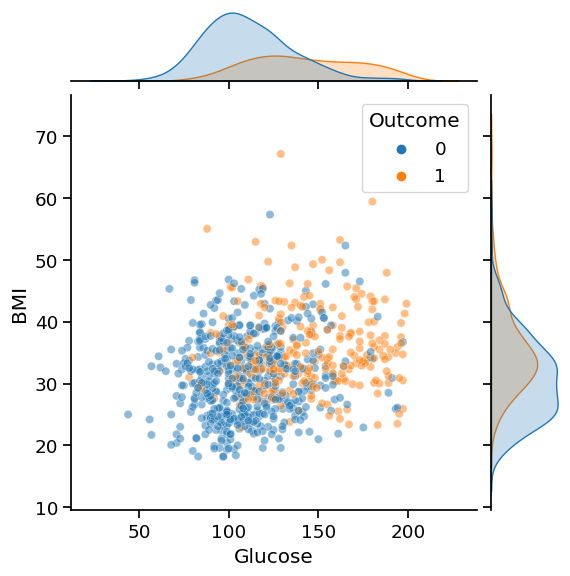

In [18]:
sns.jointplot(x='Glucose', y='BMI', data=df, hue='Outcome', alpha=0.5)
plt.show()

Jointplot indicates that most diabetic cases cluster at high Glucose and BMI values


## Correlation matrix

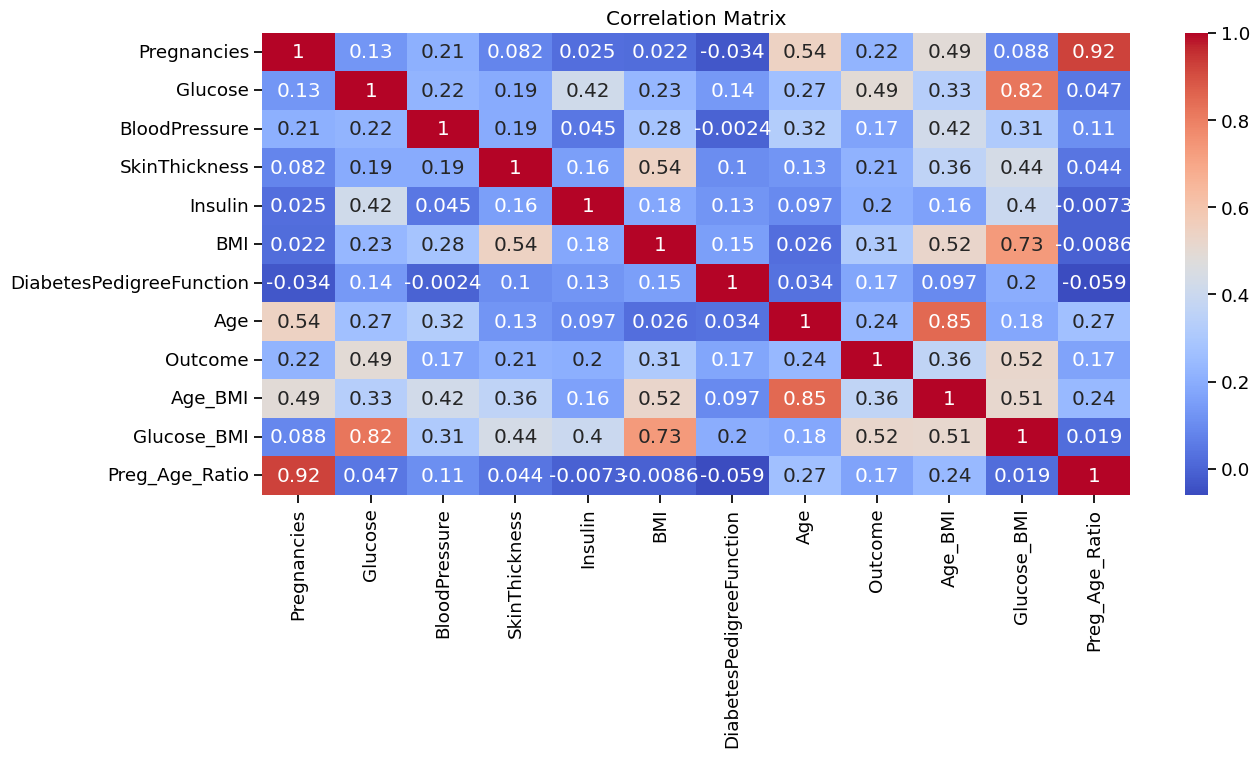

In [19]:
plt.figure(figsize=(14,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Glucose is most strongly correlated with diabetes outcome.


## Features Distribution by Class

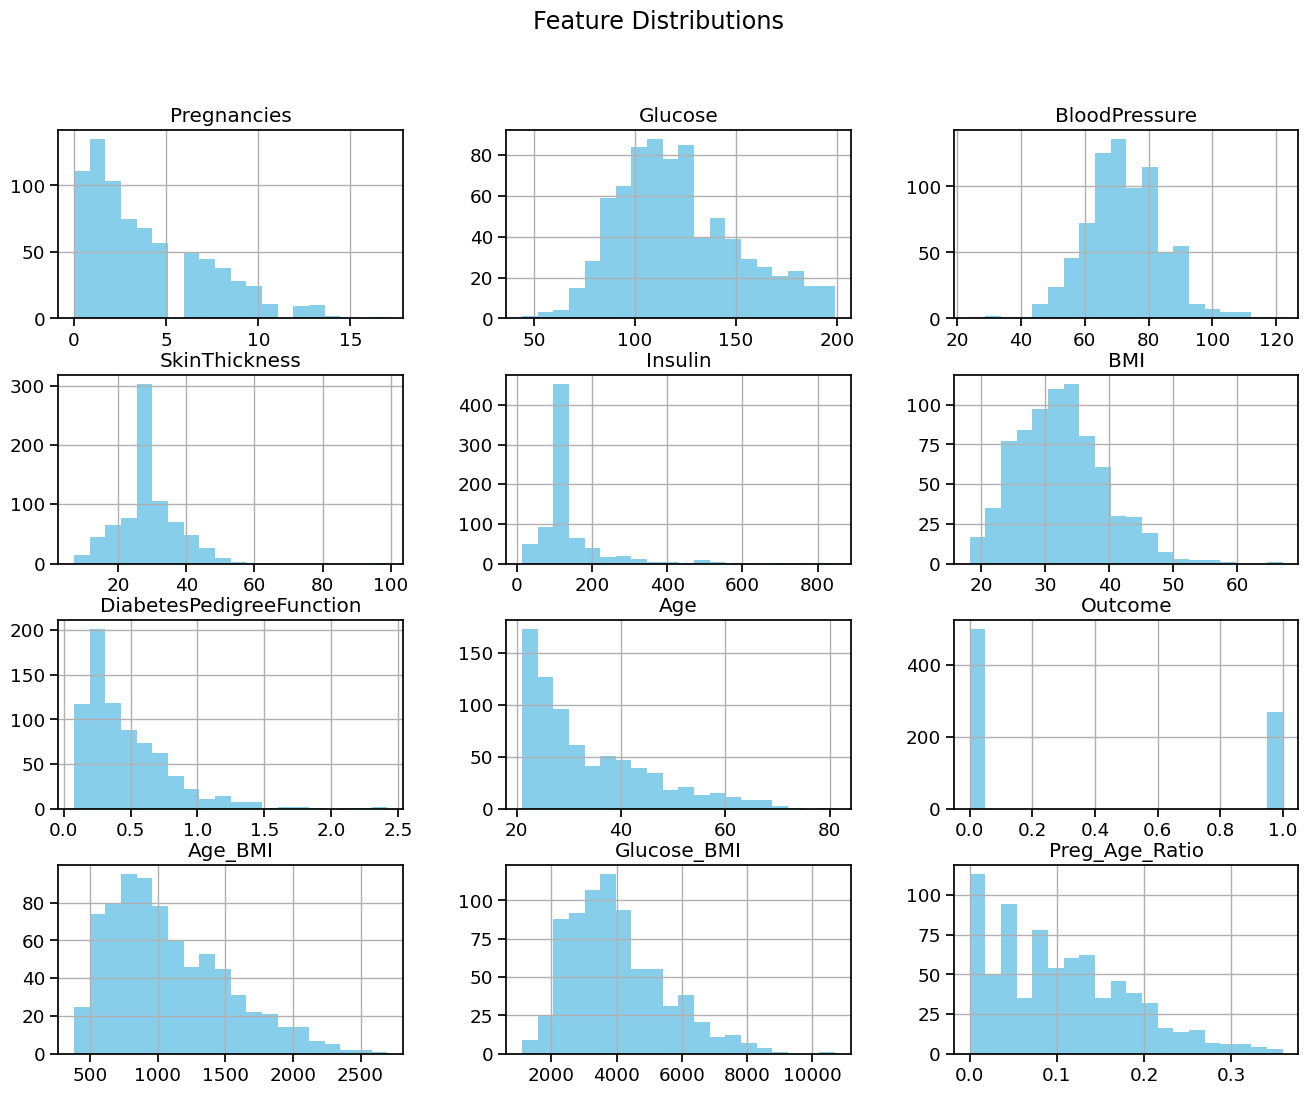

In [20]:
df.hist(bins=20, figsize=(16,12), color='skyblue')
plt.suptitle('Feature Distributions')
plt.show()

Diabetic patients tend to have higher Glucose, BMI, and Age


## Boxplots for Key Features


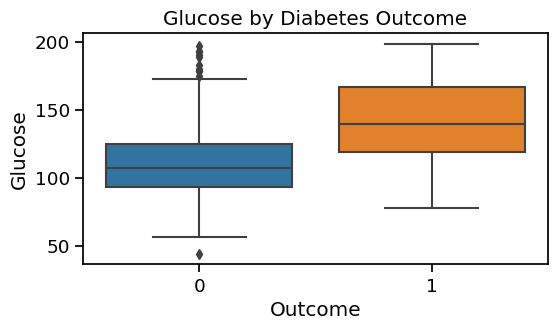

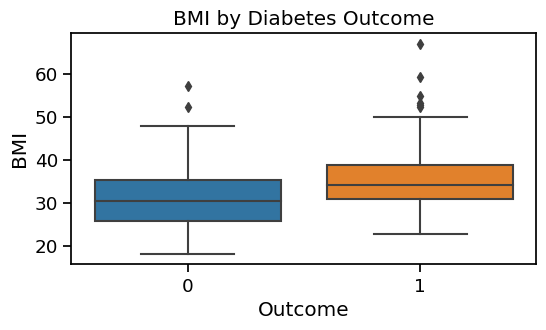

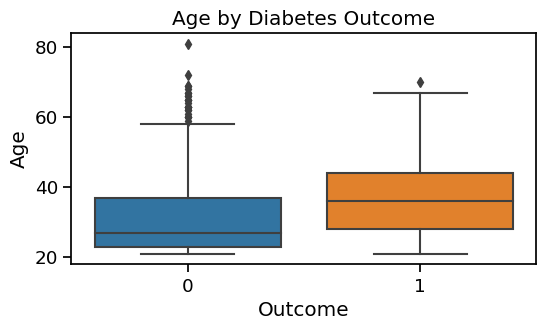

In [21]:
for col in ['Glucose','BMI','Age']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} by Diabetes Outcome')
    plt.show()

Boxplots show median and mean Glucose, BMI, and Age are noticeably higher among diabetic patients.


## Grouped Insights

## Diabetes Rate by Age Group

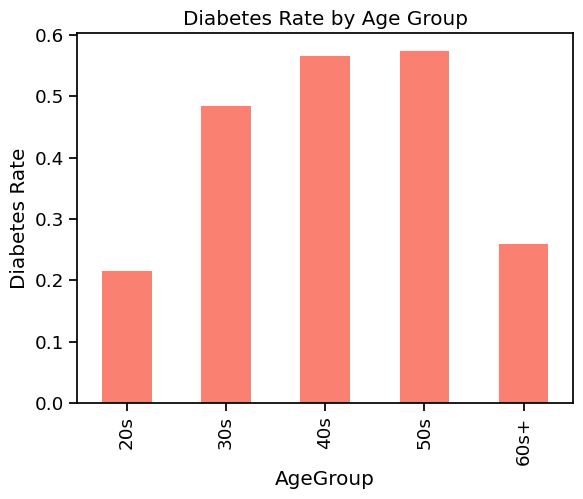

In [22]:
age_diabetes = df.groupby('AgeGroup')['Outcome'].mean()
age_diabetes.plot(kind='bar', color='salmon')
plt.title('Diabetes Rate by Age Group')
plt.ylabel('Diabetes Rate')
plt.show()

Diabetes rate increases sharply after age 40, especially among those with higher BMI.

## BMI Distribution by Outcome

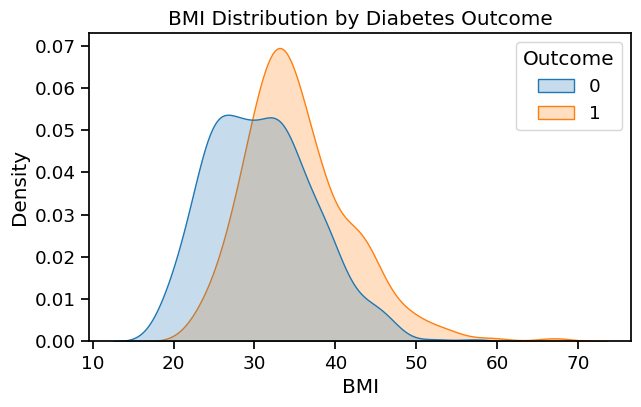

In [23]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=df, x="BMI", hue="Outcome", fill=True, common_norm=False)
plt.title('BMI Distribution by Diabetes Outcome')
plt.show()

Individuals with higher BMI are more likely to be diabetic, as shown by the distinct distribution curves.


# Data Preparation for Modeling

In [24]:
X = df.drop(columns=['Outcome', 'AgeGroup', 'BMI_Category'])
y = df['Outcome']

Remove derived columns to avoid data leakage


## Train-Test Split


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

Data was split in a stratified manner to ensure fair model evaluation.

## Scaling

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Standard scaling helps models converge and handle feature variance.

## Class Balance: SMOTE

In [27]:
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

SMOTE was applied to balance the dataset by synthetically generating minority class samples, improving recall and model fairness.


## Baseline Model

In [28]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test_scaled)
print('Baseline F1-Score:', f1_score(y_test, y_pred_dummy))
print('Baseline Accuracy:', accuracy_score(y_test, y_pred_dummy))


Baseline F1-Score: 0.0
Baseline Accuracy: 0.6493506493506493


## Feature Selection

In [29]:
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5)
selector.fit(X_train_res, y_train_res)
print("Selected features:", X.columns[selector.support_])

Selected features: Index(['Glucose', 'BMI', 'Age', 'Glucose_BMI', 'Preg_Age_Ratio'], dtype='object')


Feature selection indicates the top predictors remain Glucose, BMI, and Age.

The baseline (dummy) classifier yields very low F1-score, highlighting the need for a real predictive model.


# Modeling (Logistic, RF, XGBoost)

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic Regression,0.721,0.587,0.685,0.632,0.813
Random Forest,0.708,0.582,0.593,0.587,0.818
XGBoost,0.727,0.607,0.630,0.618,0.806


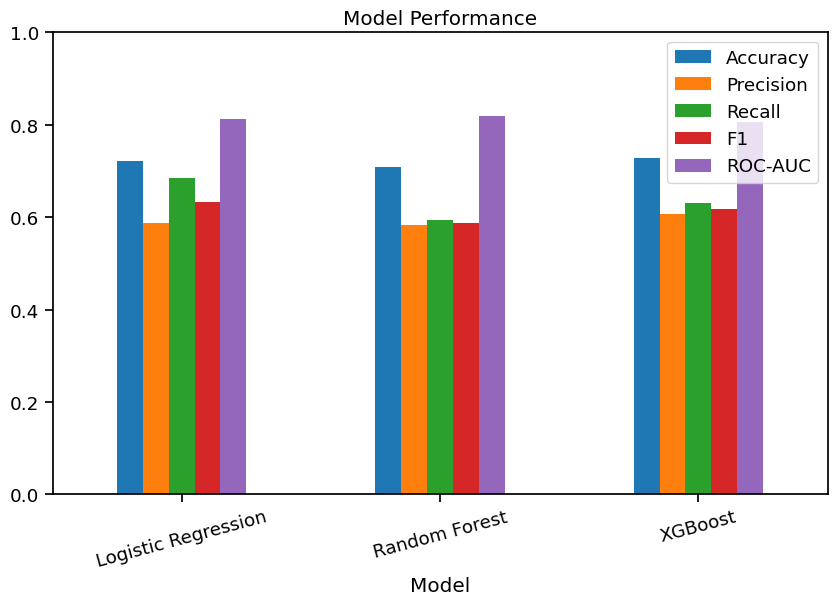

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=RANDOM_SEED, scale_pos_weight= (y==0).sum()/(y==1).sum(), eval_metric='logloss', use_label_encoder=False)
}

results = []
y_probas = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })
    y_probas[name] = y_proba

result_df = pd.DataFrame(results).set_index('Model')
result_df = result_df.round(3)
display(result_df)
result_df.plot(kind='bar', figsize=(10,6), ylim=(0,1), title='Model Performance', rot=15)
plt.show()


Main Insights:

- **Logistic Regression** achieved the **highest F1-score** (0.63) and **Recall** (0.69), indicating it is best at balancing between catching diabetic cases and limiting false positives.
- **Random Forest** and **XGBoost** showed slightly higher **ROC-AUC** values (0.82 and 0.81), which means they are strong at distinguishing between diabetic and non-diabetic cases overall.
- **XGBoost** recorded the **highest Accuracy** (0.73) and **Precision** (0.61), suggesting it is slightly better at minimizing false positives but may miss some diabetic cases (lower Recall).
- All models performed comparably in terms of **ROC-AUC**, showing robust discrimination capabilities.

**Best Model Recommendation:**
- **Logistic Regression** is the most balanced model in this scenario. It offers the best trade-off between **Recall** (identifying most diabetic patients) and **F1-score** (balancing Precision and Recall), making it the preferred choice for clinical risk screening where missing positive cases is costly.

### 🔗 **Metric Explanation:**
- **Accuracy:** Overall correctness of the model.
- **Precision:** Out of all predicted diabetics, how many were correct.
- **Recall:** Out of all actual diabetics, how many were detected.
- **F1-score:** Harmonic mean of Precision and Recall (best for imbalanced data).
- **ROC-AUC:** Measures model's ability to distinguish between classes (higher = better).

---

#### **Summary Table:**

| Model               | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression | 0.72     | 0.59      | 0.69   | 0.63     | 0.81    |
| Random Forest       | 0.71     | 0.58      | 0.59   | 0.59     | 0.82    |
| XGBoost             | 0.73     | 0.61      | 0.63   | 0.62     | 0.81    |

---

> **Visualization Insight:**  
> The bar chart visually compares each model across all metrics.  
> Notice how **Logistic Regression** leads in F1 and Recall, while **Random Forest** slightly edges in ROC-AUC.  
> **XGBoost** delivers the highest overall accuracy and precision, but with a modest drop in recall.

---

**In conclusion:**  
- If your goal is **maximum detection** of diabetic patients (high recall), choose **Logistic Regression**.
- If you prioritize overall accuracy and precision (with slightly more missed positives), **XGBoost** is an alternative.
- All three models show strong ROC-AUC (>0.80), confirming solid discriminative power.

---

## Precision-Recall Curve

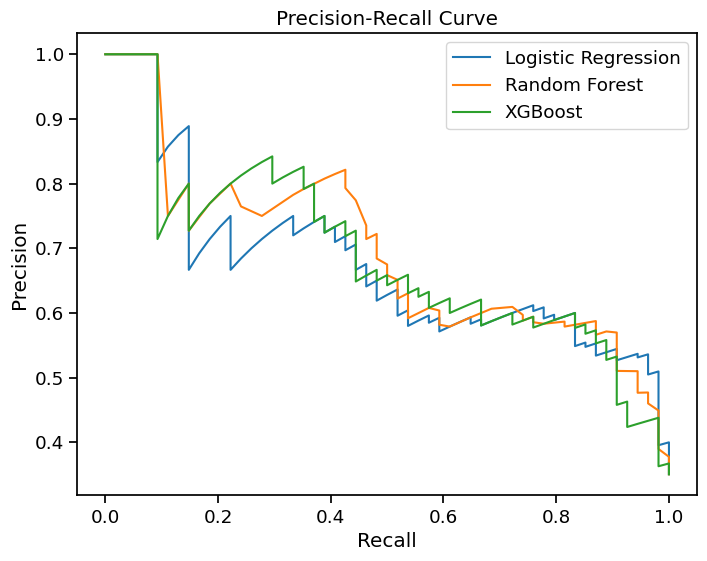

In [31]:
plt.figure(figsize=(8,6))
for name, y_proba in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name}")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Precision-Recall curves are especially informative with imbalanced datasets.

## ROC Curve

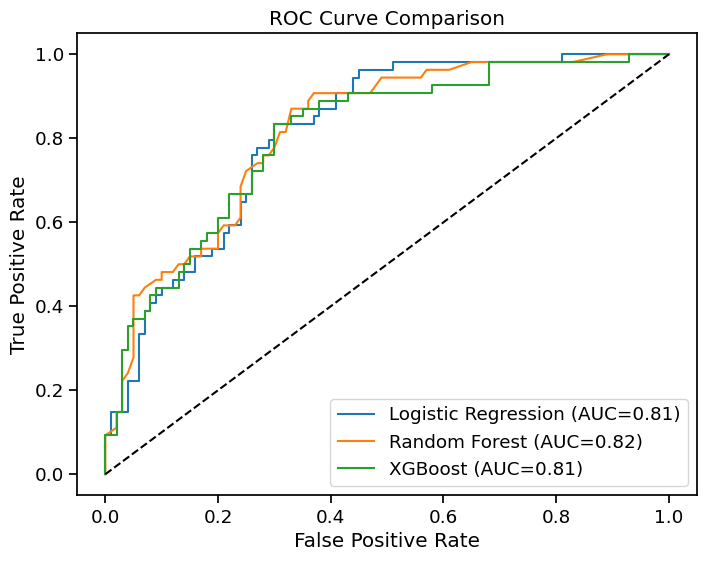

In [32]:
plt.figure(figsize=(8,6))
for name, y_proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

All models perform better than random guessing, with XGBoost showing the best AUC.

## Classification Reports

In [33]:
for name, model in models.items():
    print(f"\nClassification report for {name}:")
    print(classification_report(y_test, model.predict(X_test_scaled)))



Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154


Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       100
           1       0.58      0.59      0.59        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154


Classification report for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.61      0.63      0.62        54

    accuracy                           0.73       154
  

Classification report helps to see detailed performance for each class (recall for diabetes class).


## Hyperparameter Tuning

In [34]:
params = {'n_estimators':[50,100,200], 'max_depth':[3,5,10,None]}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    params, cv=5, scoring='f1'
)
grid.fit(X_train_res, y_train_res)
print("Best RF params:", grid.best_params_)



Best RF params: {'max_depth': None, 'n_estimators': 200}


Random Forest hyperparameters were optimized via grid search to achieve the best possible performance.


# Model Interpretation

Feature Importance (Random Forest)

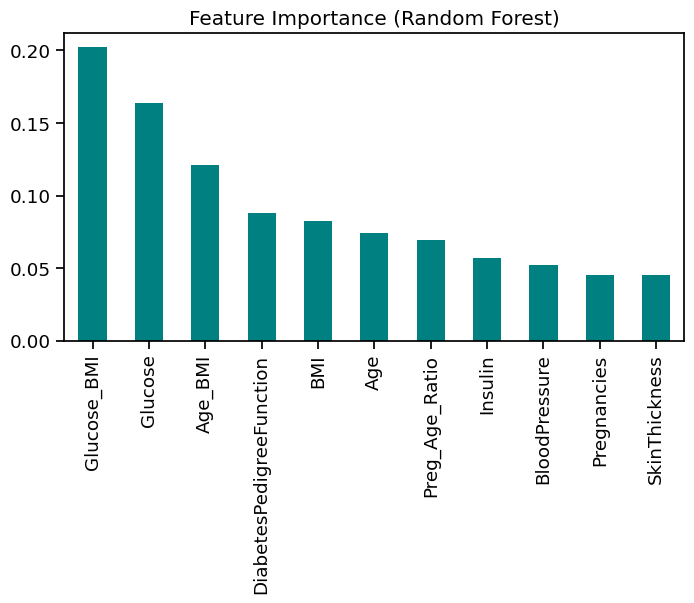

In [35]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', color='teal', figsize=(8,4))
plt.title("Feature Importance (Random Forest)")
plt.show()


Feature importance analysis confirms Glucose, BMI, and Age are the most influential predictors for diabetes outcome.


# Error Analysis & Threshold Analysis

## Confusion Matrix

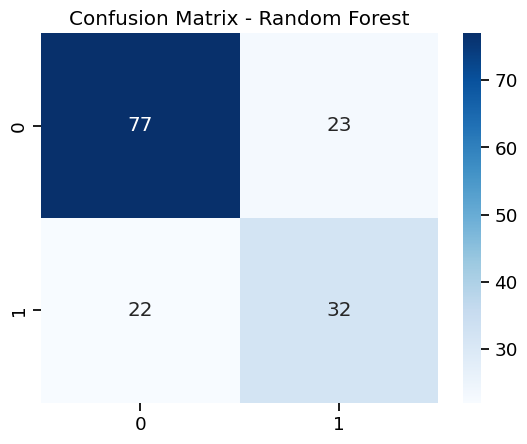

In [36]:
y_pred_best = models['Random Forest'].predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Most misclassifications (especially false negatives) occur in cases with borderline Glucose/BMI, suggesting a need for additional features.


## Investigate Errors

In [37]:

wrong_preds = X_test.copy()
wrong_preds['Actual'] = y_test
wrong_preds['Predicted'] = y_pred_best
wrong_preds = wrong_preds[wrong_preds['Actual'] != wrong_preds['Predicted']]
false_neg = wrong_preds[(wrong_preds['Actual']==1) & (wrong_preds['Predicted']==0)]
display(false_neg.head(3))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_BMI,Glucose_BMI,Preg_Age_Ratio,Actual,Predicted
630,7,114.0,64.0,29.0,125.0,27.4,0.732,34,931.6,3123.6,0.200000,1,0
387,8,105.0,100.0,36.0,125.0,43.3,0.239,45,1948.5,4546.5,0.173913,1,0
678,3,121.0,52.0,29.0,125.0,36.0,0.127,25,900.0,4356.0,0.115385,1,0


Most false negatives are borderline cases with moderate Glucose/BMI, indicating areas for potential feature enrichment.


## False Negatives Analysis 

In [38]:
y_pred_prob = models['Logistic Regression'].predict_proba(X_test_scaled)[:,1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)
false_neg_idx = (y_test == 1) & (y_pred_label == 0)
false_neg = X_test[false_neg_idx].copy()
false_neg['Glucose'] = df.loc[false_neg.index, 'Glucose']
false_neg['BMI'] = df.loc[false_neg.index, 'BMI']
false_neg['Age'] = df.loc[false_neg.index, 'Age']
false_neg['Model Probability'] = y_pred_prob[false_neg_idx]
display(false_neg[['Glucose', 'BMI', 'Age', 'Model Probability']].head())


,Glucose,BMI,Age,Model Probability
630,114.0,27.4,34,0.357301
678,121.0,36.0,25,0.463082
17,107.0,29.6,31,0.263050
64,114.0,32.8,42,0.442392
124,113.0,33.3,23,0.243701


## False Negatives (Distribution Plot)

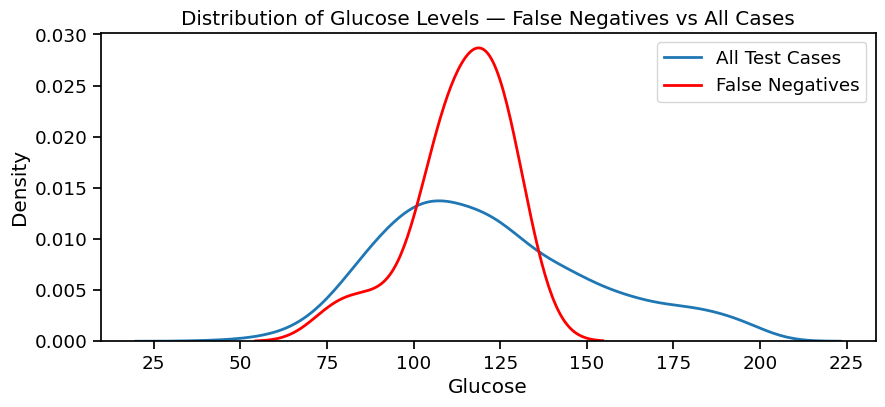

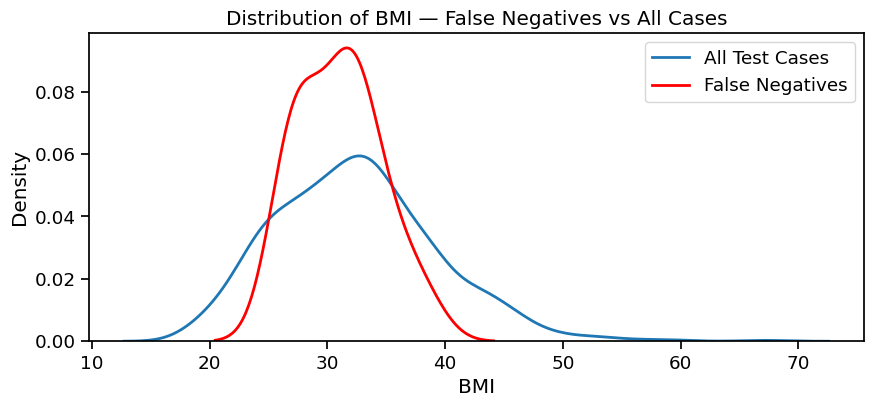

In [39]:
plt.figure(figsize=(10,4))
sns.kdeplot(df['Glucose'], label='All Test Cases', linewidth=2)
sns.kdeplot(false_neg['Glucose'], label='False Negatives', color='red', linewidth=2)
plt.title('Distribution of Glucose Levels — False Negatives vs All Cases')
plt.xlabel('Glucose')
plt.legend(); plt.show()

plt.figure(figsize=(10,4))
sns.kdeplot(df['BMI'], label='All Test Cases', linewidth=2)
sns.kdeplot(false_neg['BMI'], label='False Negatives', color='red', linewidth=2)
plt.title('Distribution of BMI — False Negatives vs All Cases')
plt.xlabel('BMI')
plt.legend(); plt.show()


The plots show that false negatives tend to cluster in the mid-range of glucose and BMI, not at the extremes. These borderline cases highlight where the model is less confident and more likely to miss actual diabetes.



## Threshold Analysis — Recall vs Precision

In [40]:
for th in [0.5, 0.4, 0.3]:
    y_pred_adj = (y_pred_prob >= th).astype(int)
    cm = confusion_matrix(y_test, y_pred_adj)
    tn, fp, fn, tp = cm.ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    print(f"Threshold: {th} | Recall: {recall:.2f} | Precision: {precision:.2f} | FN: {fn} | FP: {fp}")


Threshold: 0.5 | Recall: 0.69 | Precision: 0.59 | FN: 17 | FP: 26
Threshold: 0.4 | Recall: 0.83 | Precision: 0.57 | FN: 9 | FP: 34
Threshold: 0.3 | Recall: 0.89 | Precision: 0.54 | FN: 6 | FP: 41


Lowering the model threshold from **0.5** to **0.3** increases recall from 69% to 89%, significantly reducing the number of undetected diabetic patients. While this leads to more false positives, in clinical screening, **maximizing recall is usually preferred** to avoid missing at-risk cases. This strategy ensures that more potential diabetics are flagged for further testing, improving patient safety at the expense of some extra investigations for healthy individuals.


## Learning Curve

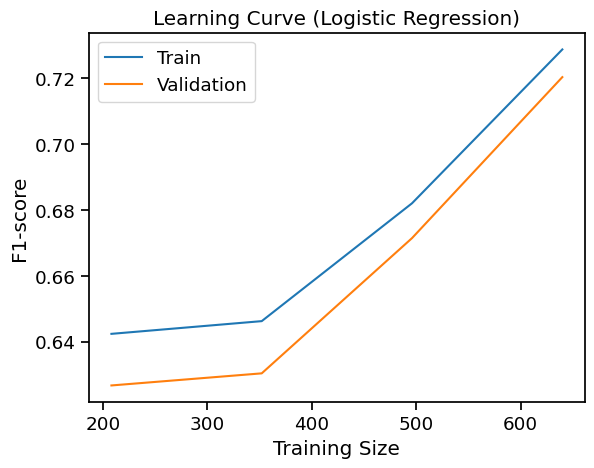

In [41]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train_res, y_train_res, cv=5, scoring='f1', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.xlabel('Training Size'); plt.ylabel('F1-score')
plt.title('Learning Curve (Logistic Regression)')
plt.legend(); plt.show()


If validation and train curves are close, model is well generalized (not overfitting).

# Key Insights & Recommendations

## Key Takeaways
- 📈 **Best Model:** Logistic Regression (F1 = 0.63)
- 🔑 **Top Features:** Glucose, BMI, Age, Pregnancies
- ⚠️ **High-Risk Group:** Age 40+, high BMI and Glucose
- 💡 **Action:** Prioritize screening for these groups; integrate model into clinical workflow for early detection.

---

## Insights & Recommendations
- **Key predictors:** Glucose, BMI, Age, and Pregnancies are the top features.
- **At-risk groups:** Individuals over 40, high BMI, and high glucose should be prioritized for screening.
- **Model deployment:** This model can be integrated into a clinic screening tool for early risk detection.
- **Future improvements:** Add more lifestyle & family history features, monitor model drift, and retrain periodically.

**Limitations:** The dataset lacks information on lifestyle, medication, or family history. Future work should include more features and external validation.



*Note: This model supports, but does not replace, professional medical diagnosis.*
